In [1]:
from genetic_algorithm import algorithms, selectors, individuals, crossover
from deap import base, creator, tools
import numpy as np
import random

# Definir los parámetros del problema
IND_SIZE = 12  # Número de genes en cada individuo

# Crear los tipos de fitness e individuo en DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", individuals.truss_like, fitness=creator.FitnessMax)

# Configuración del entorno evolutivo utilizando DEAP
toolbox = base.Toolbox()

# Registro de las funciones
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", lambda: creator.Individual(np.array([[random.choice([0, 1]) for _ in range(IND_SIZE)] for _ in range(2)])))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", lambda ind: ind.evaluate())
toolbox.register("clone", lambda ind: ind.clone())
toolbox.register("mutate", lambda ind: ind.mutate())
toolbox.register("mate", crossover.mix_crossover)
toolbox.register("select", selectors.select_individuals_elitist)

n_pop = 50
pop = toolbox.population(n=n_pop)

hall_of_fame = tools.HallOfFame(1)

# Definir estadísticas
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


population, logbook = algorithms.ea(pop, toolbox, 100, halloffame= hall_of_fame, stats= stats)

pm:2.5: 100%|██████████| 100/100 [02:03<00:00,  1.24s/it]


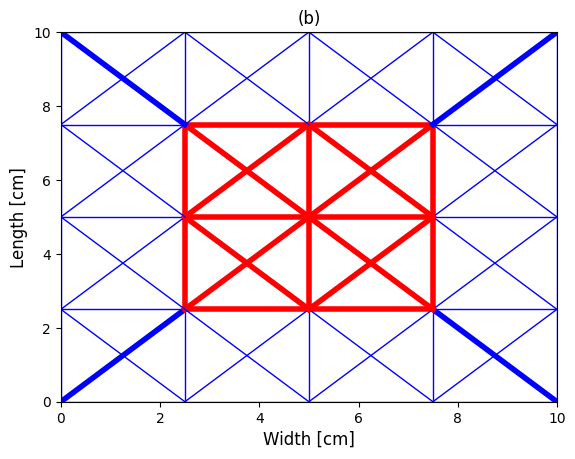

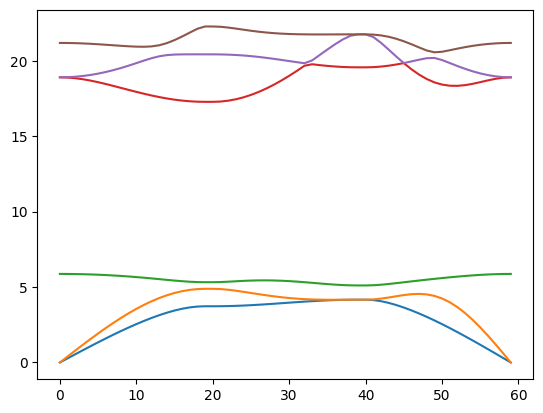

11.404344987731086


In [2]:
best_individual = hall_of_fame[0]
best_individual.plot()
print(best_individual.bandgap)

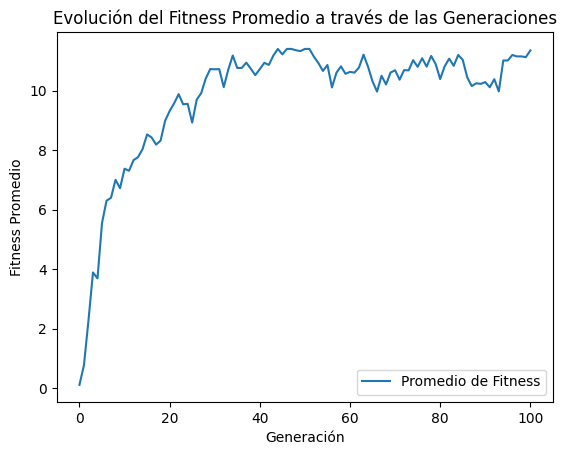

In [3]:
import matplotlib.pyplot as plt
gen, max = logbook.select("gen", "avg")

plt.plot(gen, max, label="Promedio de Fitness")
plt.xlabel("Generación")
plt.ylabel("Fitness Promedio")
plt.title("Evolución del Fitness Promedio a través de las Generaciones")
plt.legend()
plt.show()

In [4]:
print(logbook)      

gen	nevals	pm 	avg     	std        	min      	max     
0  	50    	   	0.107905	0.262906   	0.01     	0.836488
1  	48    	5  	0.772224	1.22561    	0.01     	3.81039 
2  	41    	5  	2.27645 	1.7801     	0.01     	7.46353 
3  	40    	5  	3.88815 	1.69358    	0.01     	5.96386 
4  	44    	5.4	3.6891  	1.98012    	0.0480084	5.96386 
5  	35    	5.2	5.54588 	1.18732    	1.86505  	6.63398 
6  	31    	5.2	6.30042 	0.26294    	5.60536  	6.63398 
7  	40    	5.4	6.39998 	1.08342    	2.36709  	7.76855 
8  	35    	5.3	7.0037  	0.592589   	6.3213   	7.80768 
9  	44    	5.3	6.72066 	0.904778   	5.28186  	7.87229 
10 	38    	5.3	7.37713 	0.888783   	5.85023  	8.77921 
11 	42    	5.3	7.30811 	1.27975    	2.47901  	8.40371 
12 	36    	5.5	7.66537 	1.1303     	2.94893  	9.49238 
13 	41    	5.6	7.76694 	1.04696    	4.73623  	9.29029 
14 	38    	5.5	8.03778 	1.40945    	4.49297  	9.29029 
15 	37    	5.6	8.52955 	0.808141   	6.80555  	9.29029 
16 	37    	5.3	8.42777 	1.09491    	5.38188  	9.49238 
17 	42    